# <div align='center' id="top"> Face Matching task  </div>

## Facematching Pipeline:
- load the model buffalo_l from `InsightFace`
- input 2 faces to the model and get their respective embeddings
- match the faces through multistace matching system that include:
    - Angular distance
    - Cosine Similarity 
    - Eucledian Distance

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import insightface

# Load face analysis model
face_model = insightface.app.FaceAnalysis(name='buffalo_l', providers=['CPUExecutionProvider'])
face_model.prepare(ctx_id=0)

def angular_distance(v1, v2):
    cos_sim = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    return np.arccos(np.clip(cos_sim, -1.0, 1.0)) * (180 / np.pi)  # degrees

def match_faces(img1_path, img2_path, visualize=True):
    # Load and detect
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    faces1 = face_model.get(img1)
    faces2 = face_model.get(img2)

    if not faces1 or not faces2:
        return {"error": "Face not detected in one or both images."}

    # Largest face in both
    face1 = sorted(faces1, key=lambda f: (f.bbox[2]-f.bbox[0]) * (f.bbox[3]-f.bbox[1]), reverse=True)[0]
    face2 = sorted(faces2, key=lambda f: (f.bbox[2]-f.bbox[0]) * (f.bbox[3]-f.bbox[1]), reverse=True)[0]

    # Embeddings
    emb1 = face1.embedding / np.linalg.norm(face1.embedding)
    emb2 = face2.embedding / np.linalg.norm(face2.embedding)

    # Similarity metrics
    cos_sim = np.dot(emb1, emb2)
    eucl_dist = np.linalg.norm(emb1 - emb2)
    angle = angular_distance(emb1, emb2)

    # Thresholds (empirical tuning works best)
    cos_thresh = 0.4
    eucl_thresh = 1.0
    angle_thresh = 50  # degrees

    # Multi-stage logic (majority voting or weighted rules)
    votes = 0
    if cos_sim > cos_thresh: votes += 1
    if eucl_dist < eucl_thresh: votes += 1
    if angle < angle_thresh: votes += 1

    is_match = votes >= 1  # 1 out of 3 conditions must be true

    # Optional visualization
    if visualize:
        def crop_face(img, bbox):
            x1, y1, x2, y2 = map(int, bbox)
            return cv2.cvtColor(cv2.resize(img[y1:y2, x1:x2], (112, 112)), cv2.COLOR_BGR2RGB)

        face_img1 = crop_face(img1, face1.bbox)
        face_img2 = crop_face(img2, face2.bbox)

        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[0].imshow(face_img1)
        axes[0].set_title("Face 1")
        axes[0].axis("off")

        axes[1].imshow(face_img2)
        axes[1].set_title("Face 2")
        axes[1].axis("off")

        title = f"{'Match' if is_match else 'Mismatch'} | Cos: {cos_sim:.2f} | Euc: {eucl_dist:.2f} | Angle: {angle:.1f}°"
        title_color = "green" if is_match else "red"
        plt.suptitle(title, color=title_color, fontsize=13)
        plt.tight_layout()
        plt.show()

    return {
        "cosine_similarity": round(float(cos_sim), 4),
        "euclidean_distance": round(float(eucl_dist), 4),
        "angular_distance_deg": round(float(angle), 2),
        "is_match": bool(is_match),
        "votes_passed": votes,
        "criteria": {
            "cosine > 0.4": cos_sim > cos_thresh,
            "euclidean < 1.4": eucl_dist < eucl_thresh,
            "angle < 50°": angle < angle_thresh
        }
    }


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Mahmoud/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Mahmoud/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Mahmoud/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Mahmoud/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Mahmoud/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112,

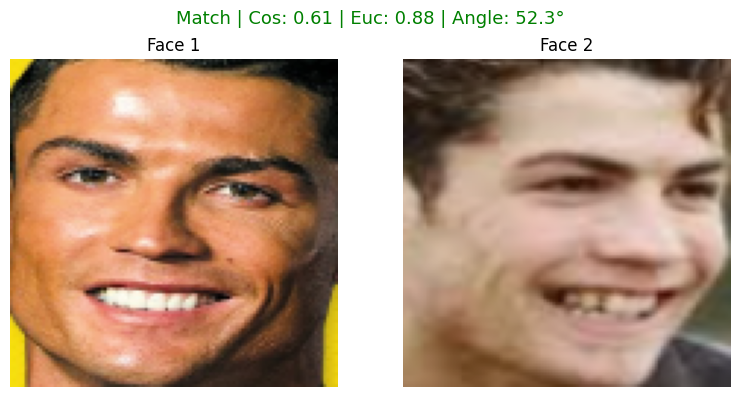

{'cosine_similarity': 0.6111, 'euclidean_distance': 0.8819, 'angular_distance_deg': 52.33, 'is_match': True, 'votes_passed': 2, 'criteria': {'cosine > 0.6': True, 'euclidean < 1.2': True, 'angle < 50°': False}}


In [ ]:
res = match_faces("oldcr7.png", "youngcr7.png")
print(res)

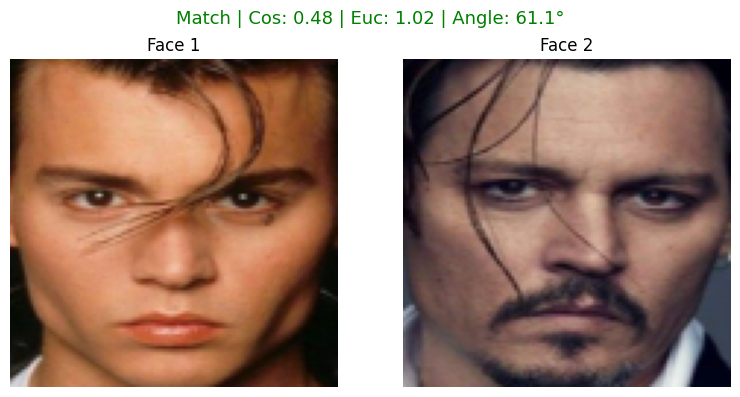

{'cosine_similarity': 0.4832, 'euclidean_distance': 1.0166, 'angular_distance_deg': 61.1, 'is_match': True, 'votes_passed': 1, 'criteria': {'cosine > 0.4': True, 'euclidean < 1.4': False, 'angle < 50°': False}}


In [3]:
res = match_faces("young.png", "old.png")
print(res)

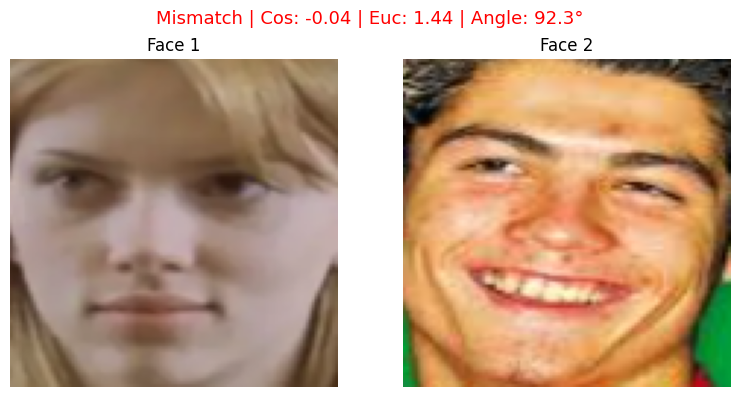

{'cosine_similarity': -0.0405, 'euclidean_distance': 1.4426, 'angular_distance_deg': 92.32, 'is_match': False, 'votes_passed': 0, 'criteria': {'cosine > 0.4': False, 'euclidean < 1.4': False, 'angle < 50°': False}}


In [4]:
res = match_faces("youngs.png", "young2cr7.png")
print(res)

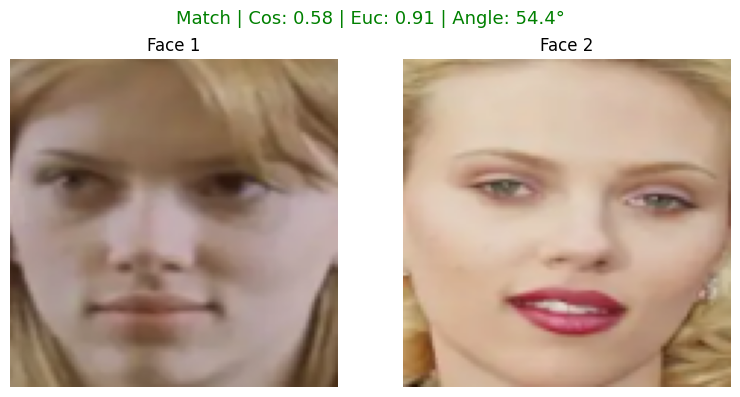

{'cosine_similarity': 0.5822, 'euclidean_distance': 0.9141, 'angular_distance_deg': 54.4, 'is_match': True, 'votes_passed': 2, 'criteria': {'cosine > 0.4': True, 'euclidean < 1.4': True, 'angle < 50°': False}}


In [5]:
res = match_faces("youngs.png", "olds.png")
print(res)